In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [ ]:
from resolution import energy_smearing
import mkl

mkl.set_num_threads(1)
from fluxes import parabola_index, power_law
import pickle
from collections import namedtuple
from itertools import product
from copy import copy, deepcopy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
import settings as st
from settings import plt
from tools import array_source_interp, poisson_llh, get_scaler, get_mids
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from tools import add_plane, add_obj
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
import astropy.units as u
from aeff_calculations import setup_aeff_grid
from glob import glob
from astropy.constants import h


# max value of angular distance
delta_psi_max = 1
psi2_bins = np.linspace(
    0, delta_psi_max**2, num=int(delta_psi_max**2 * st.bins_per_psi2) + 1
)
psi2_mids = get_mids(psi2_bins)

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [ ]:
E = 1 * u.erg
nu = 1 * u.Hz
Enu = nu * h

# unit conversion
erg_to_GeV = E.to(u.GeV).value
nu_to_GeV = Enu.to(u.GeV).value
nu_to_erg = Enu.to(u.erg).value

print(erg_to_GeV, nu_to_GeV, nu_to_erg)

624.1509074460764 4.135667696923859e-24 6.62607015e-27


In [ ]:
detector_configurations = {
    "IceCube": (["IceCube"], [1]),
    "IceCube-Gen2": (["IceCube"], [st.GEN2_FACTOR]),
    "P-ONE": (["IceCube", "P-ONE"], [1, 1]),
    "KM3NeT": (["IceCube", "KM3NeT"], [1, 1]),
    "Plenum-1": (["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"], [1, 1, 1, 1]),
    "Plenum-2": (["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"], [st.GEN2_FACTOR, 1, 1, 1]),
}

In [ ]:
# energy resolution files
e_res_files = {
    "baseline": join(st.LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(st.LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(st.LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        st.LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        st.LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

## helper functions

In [ ]:
def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5, 
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new

## Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [ ]:
with open(join(st.LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)

with open(join(st.LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)
# print(aeff_2d_full.keys())
# print(aeff_2d_full["IceCube"])

## Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [ ]:
with open(join(st.LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d_full["IceCube"], verbose=True))

Elementary arithmetic possible.
True


## Energy resolution function

In [ ]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true


In [ ]:

# checking if matrix multiplication is possible
print(aeff_2d_full["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d_full["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


## Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

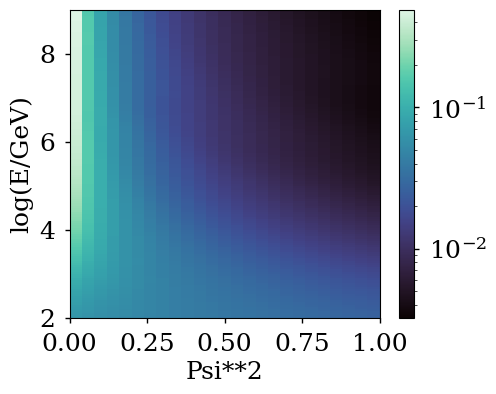

In [ ]:
# angular resolution
with open(join(st.LOCALPATH, f"Psi2-{delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()
e_psi2_grid.plot(norm=LogNorm())

## Flux definition

In [ ]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## calculate number ov events

(very blackmetal)

## Log Parabola

In [ ]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid
# TXS parameters
with open("../../local/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")

In [ ]:
Alpha = 2
E_para_norm = 1e6
Beta = 1
PHI_lp = 2.6640985514261466e-22 # :)
conservative_livetime = 7.5 * 365 * 24 * 3600

logp_flux = LogP_flux(PHI_lp, Alpha, Beta, E_para_norm, "log-parabola")

ident = "IceCube"
# check that the bins match
aeff_factor_signal = calc_aeff_factor(
    aeff_2d_full[ident], dec=0, livetime=conservative_livetime, **src_config
)


k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=logp_flux,
)
print("n events", np.sum(k_s)) 

aeff_factor_signal = calc_aeff_factor(
    aeff_2d_full[ident], dec=0, livetime=st.LIVETIME, **src_config
)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("n events", np.sum(k_s)) 

n events 0.9999999999999998
n events 4.975683022210519


# Models


## setup

In [ ]:
base_dct = {"src_name": 0, "model_name": 0, "state": 0, "bf_or_band": 0, "N_nu(IC)": 0, "model_spline": 0, "dec/rad": 0, "livetime/s": 0}
all_models = []

### Fang & Metzger GRB model

In [ ]:
# Right ascension 13h 09m 48.08s, Declination	−23° 22′ 53.3″
gw_170817 = SkyCoord(ra="13:09:48.08", dec="-23:22:53.3", frame="icrs",  unit=(u.hourangle, u.deg))
gw_170817

<SkyCoord (ICRS): (ra, dec) in deg
    (197.45033333, -23.38147222)>

In [ ]:
grb_1000s_moderate = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_1000sec_moderate_0deg_Kimura.txt", sep="; ")
grb_1000s_optimistic = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_1000sec_optimistic_4deg_Kimura.txt", sep="; ")
grb_3d = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_3d_Fang-Metzger.txt", sep="; ")
grb_14d = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_14d_Fang-Metzger.txt", sep="; ")



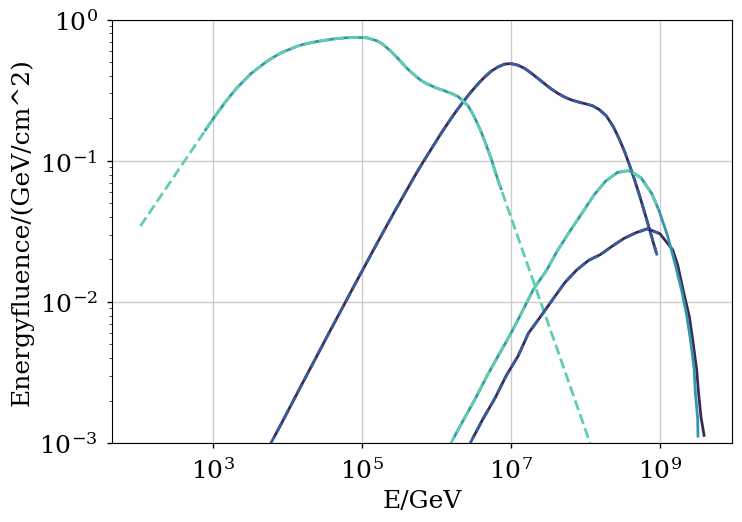

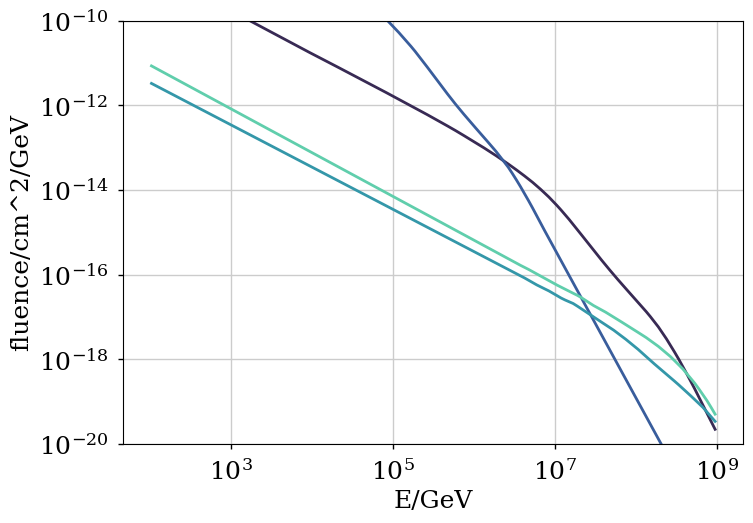

In [ ]:
grb_models = []
for label, livetime, grb in zip(
    ["1000s moderate 0deg", "1000s optimistic 4deg", "3d", "14d"],
    [1000, 1000, 3 * 24 * 3600, 14 * 24 * 3600],
    [grb_1000s_moderate, grb_1000s_optimistic, grb_3d, grb_14d],
):
    _spl = InterpolatedUnivariateSpline(
        np.log10(grb["Energy/GeV"]), np.log10(grb["Energyfluence/(GeV/cm^2)"] / (grb["Energy/GeV"]**2)), k=1
    )
    plt.figure(1)
    plt.plot(grb["Energy/GeV"], grb["Energyfluence/(GeV/cm^2)"])
    plt.plot(10**st.logE_mids, 10 ** _spl(st.logE_mids) * (10**(st.logE_mids * 2)) , ls="--")
    plt.ylabel("Energyfluence/(GeV/cm^2)")
    plt.xlabel("E/GeV")
    plt.loglog()
    plt.ylim(1e-3, 1)

    plt.figure(2)
    plt.plot(10**st.logE_mids, 10 ** _spl(st.logE_mids) )
    plt.ylabel("fluence/cm^2/GeV")
    plt.xlabel("E/GeV")
    plt.loglog()
    plt.ylim(1e-20, 1e-10)
    grb_models.append(
        {"src_name": "GW170817", "model_name": label, "state": "grb", "bf_or_band": "bestfit", "N_nu(IC)": 0, "model_spline": _spl, "dec/rad": gw_170817.dec.rad, "livetime/s": livetime}
    )
grb_models = pd.DataFrame(grb_models)

1000s moderate 0deg 1.2675724234610484
1000s optimistic 4deg 1.4212145806230425
3d 0.01789491231052564
14d 0.03955729595102141


Text(0, 0.5, '$n_\\nu$ per bin')

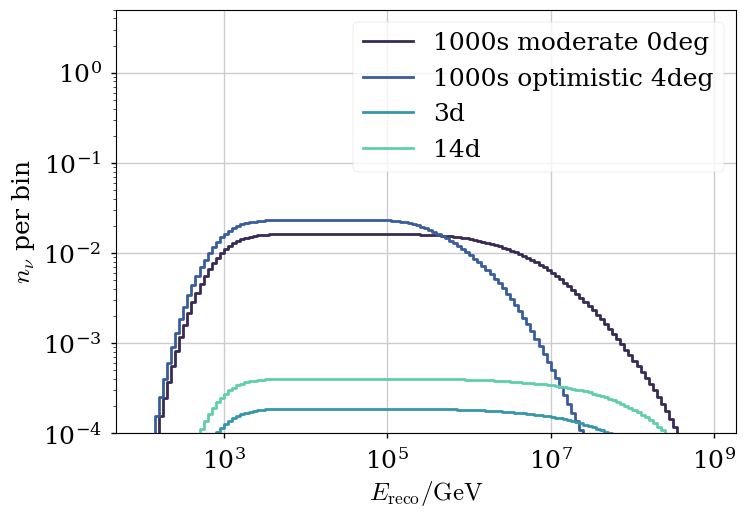

In [ ]:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d_full["IceCube"],  # ... because it's in the south
    dec=gw_170817.dec.rad,
    livetime=1,  # flare livetime is already in the fluence
    **src_config,
)
for i, row in grb_models.iterrows():
    _nev = aeff_factor_signal * 10 ** row["model_spline"](st.logE_mids)

    print(row["model_name"], np.sum(_nev))
    grb_models.loc[i, "N_nu(IC)"] = np.sum(_nev)

    plt.plot(10**st.logE_reco_mids, energy_smearing(improved_eres, _nev).sum(axis=0), label=row["model_name"], ds="steps-mid")
plt.loglog()
plt.ylim(1E-4, 5)
plt.legend()
plt.xlabel(r"$E_{\rm reco} \rm /GeV$")
plt.ylabel(r"$n_\nu$ per bin")

In [ ]:
grb_models

,src_name,model_name,state,bf_or_band,N_nu(IC),model_spline,dec/rad,livetime/s
0,GW170817,1000s moderate 0deg,grb,bestfit,1.267572,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,1000
1,GW170817,1000s optimistic 4deg,grb,bestfit,1.421215,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,1000
2,GW170817,3d,grb,bestfit,0.017895,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,259200
3,GW170817,14d,grb,bestfit,0.039557,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,1209600


### Foteini's models

In [ ]:
blazar_models = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/declinations.txt", sep=", ")
blazar_models["N_nu(IC)"] = 0
blazar_models["state"] = 0
blazar_models["bf_or_band"] = "bestfit"
blazar_models["N_nu(IC)"] = 0
blazar_models["model_spline"] = None
blazar_models["dec/rad"] = np.deg2rad(blazar_models["declination(degrees)"])
blazar_models["livetime/s"] = blazar_models["DeltaT"] * 24 * 3600


S5 0716+714 5.5e-04 livetime: 14
TXS 0506+056 1.7e-02 livetime: 175
1ES 1959+650 MJD 57285 1.8e-06 livetime: 84
1ES 1959+650 MJD 56066 3.5e-06 livetime: 46
PG 1553 113 4.9e-05 livetime: 30
3C66A 8.4e-06 livetime: 14
MRK421 1.2e-04 livetime: 13
BLLAC 9.5e-05 livetime: 7
OJ287 6.1e-03 livetime: 7
MRK501 3.9e-07 livetime: 21
S2 0109+22 6.6e-04 livetime: 21
AO 0235+164 6.6e-02 livetime: 84
S4 0954+65 1.3e-03 livetime: 28


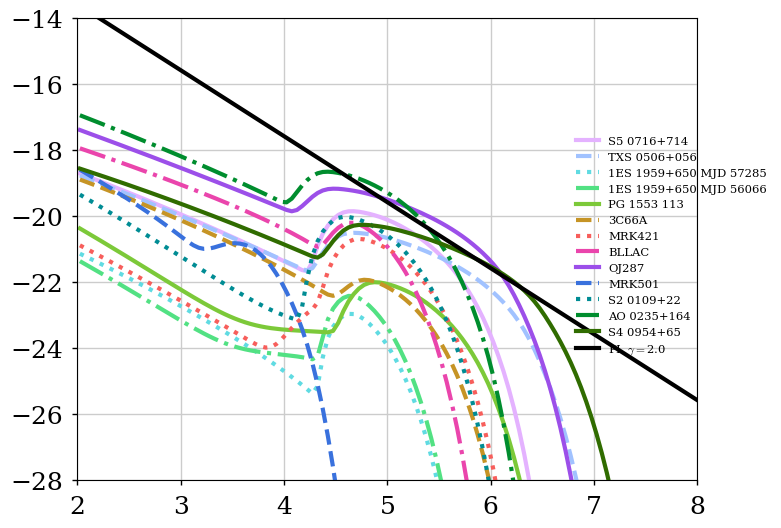

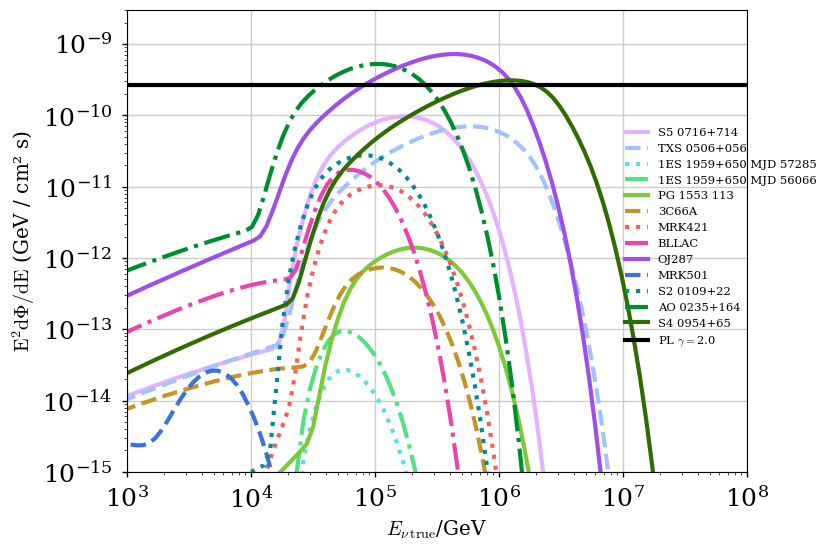

In [ ]:
# model overview
model_files = glob(
    join(st.LOCALPATH, "neutrino_models/neutrino_flux_model_B_per_flavor*.dat")
)

f2, ax2 = plt.subplots(figsize=(8, 6))
f, ax = plt.subplots(figsize=(8, 6))
mcolors = sns.cubehelix_palette(
    start=2, rot=3, dark=0.3, hue=2, light=0.8, n_colors=len(model_files)
)
lss = ["-", "--", ":", "-."]
for i, mf in enumerate(model_files):
    model = np.genfromtxt(mf)
    model_name = mf.split("per_flavor_")[-1].split(".")[0].upper().replace("_", " ")
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"],
        dec=blazar_models["dec/rad"]
        .loc[blazar_models.model_name == model_name]
        .iloc[0],
        livetime=blazar_models["livetime/s"]
        .loc[blazar_models.model_name == model_name]
        .iloc[0],
        **src_config,
    )
    mask = model[:, 1] > 0
    x = np.log10(model[:, 0][mask] / 1e9)
    y = np.log10(model[:, 1][mask] * erg_to_GeV / (model[:, 0][mask] / 1e9) ** 2)
    mask = np.isfinite(x) & np.isfinite(y)
    model_spline = InterpolatedUnivariateSpline(x[mask], y[mask])
    nev = aeff_factor_signal * 10 ** model_spline(st.logE_mids)

    blazar_models.loc[blazar_models.model_name == model_name, "N_nu(IC)"] = np.sum(nev)
    blazar_models.loc[
        blazar_models.model_name == model_name, "model_spline"
    ] = model_spline
    print(
        model_name,
        f"{np.sum(nev):1.1e}",
        f"livetime: {blazar_models['DeltaT'].loc[blazar_models.model_name == model_name]}",
    )

    ax.plot(
        model[:, 0] / 1e9,
        model[:, 1] * erg_to_GeV,
        lw=3,
        label=model_name,
        color=mcolors[i],
        ls=lss[i % 4],
    )
    ax2.plot(
        st.logE_mids,
        model_spline(st.logE_mids),
        lw=3,
        label=model_name,
        color=mcolors[i],
        ls=lss[i % 4],
    )

# txs fit:
x_evals = np.logspace(0, 9, 100)
y_scaling = 2
pl = power_law(x_evals, E0_TXS, GAMMA_TXS, PHI_TXS)
ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_TXS}",
    color="k",
    alpha=1,
    lw=3,
)
ax2.plot(
    np.log10(x_evals),
    np.log10(pl),
    label=rf"PL $\gamma=${GAMMA_TXS}",
    color="k",
    alpha=1,
    lw=3,
)
ax2.set_ylim(-28, -14)
ax2.set_xlim(2, 8)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize="x-large")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize="x-large")
ax.set_ylim(1e-15, 0.3e-8)
ax.set_xlim(1e3, 1e8)
f.legend(loc="center right", frameon=False, bbox_to_anchor=(1, 0.5), fontsize="small")
f2.legend(loc="center right", frameon=False, bbox_to_anchor=(1, 0.5), fontsize="small")

In [ ]:
blazar_models

,model_name,declination(degrees),src_name,DeltaT,N_nu(IC),state,bf_or_band,model_spline,dec/rad,livetime/s
0,TXS 0506+056,5.7,TXS 0506+056,175,1.740735e-02,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.099484,15120000
1,3C66A,43.0,3C 66A,14,8.424019e-06,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.750492,1209600
2,BLLAC,42.3,BL Lac,7,9.463189e-05,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.738274,604800
3,OJ287,20.1,OJ 287,7,6.052772e-03,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.350811,604800
4,PG 1553 113,11.2,PG 1553+113,30,4.948788e-05,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.195477,2592000
5,AO 0235+164,16.6,AO 0235+164,84,6.643963e-02,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.289725,7257600
6,S5 0716+714,71.4,S5 0716+714,14,5.523258e-04,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.246165,1209600
7,MRK501,39.8,Mrk 501,21,3.946691e-07,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.694641,1814400
8,MRK421,38.2,Mrk 421,13,1.167620e-04,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.666716,1123200
9,1ES 1959+650 MJD 56066,20.0,1ES 1959+65,46,3.536516e-06,0,bestfit,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.349066,3974400


### Xavier's models

In [ ]:
# J2000 coordinates are RA = 15:04:24.98, Dec = +10:29:39.2
# " If you’re looking for “J2000” coordinates, and aren’t sure if you want to use this or FK5, you probably want to use ICRS.  " :)
pks1502 = SkyCoord(ra="15:04:24.98", dec="+10:29:39.2", frame="icrs",  unit=(u.hourangle, u.deg))
flare_files = glob(join(st.LOCALPATH, "neutrino_models/*.csv"))
# for the legend because I am lazy
style = {
    "proton-synchrotron": dict(label="proton-synchrotron", color="darkred", ls="-"),
    "ext_field_a": dict(label="ext_field_a", color="tab:blue", ls=":"),
    "lepto-hadronic": dict(label="lepto-hadronic", color="tab:orange", ls="--"),
}

Text(0.5, 0, 'E/GeV')

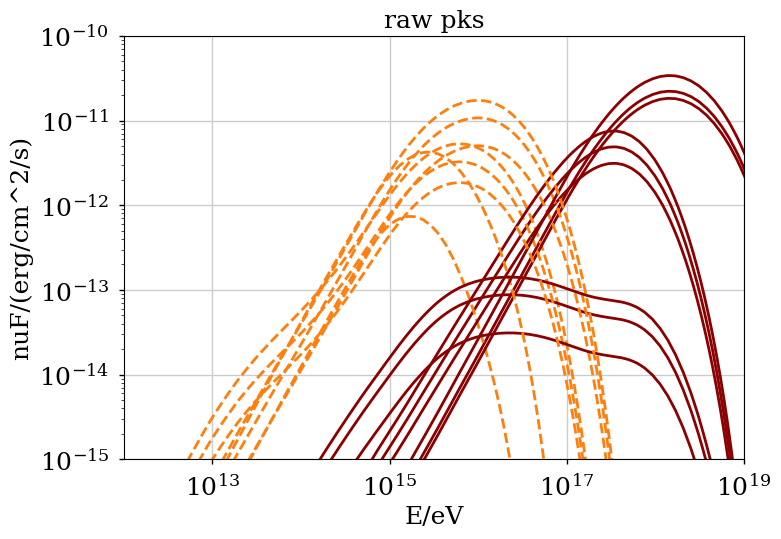

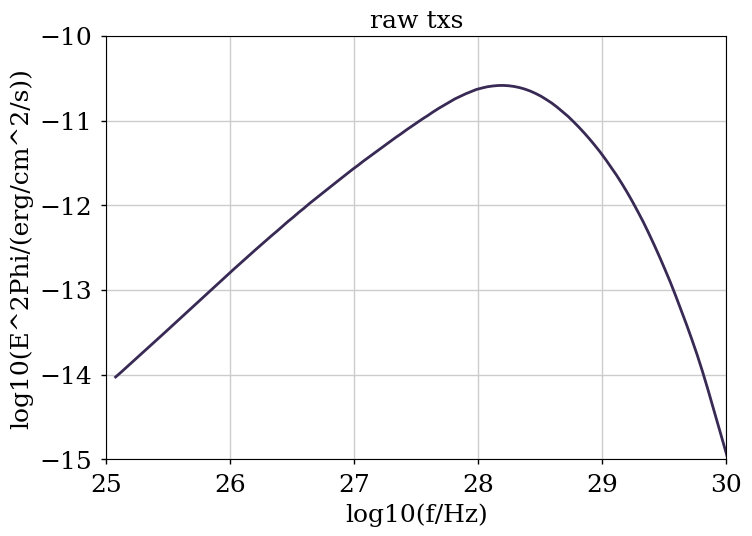

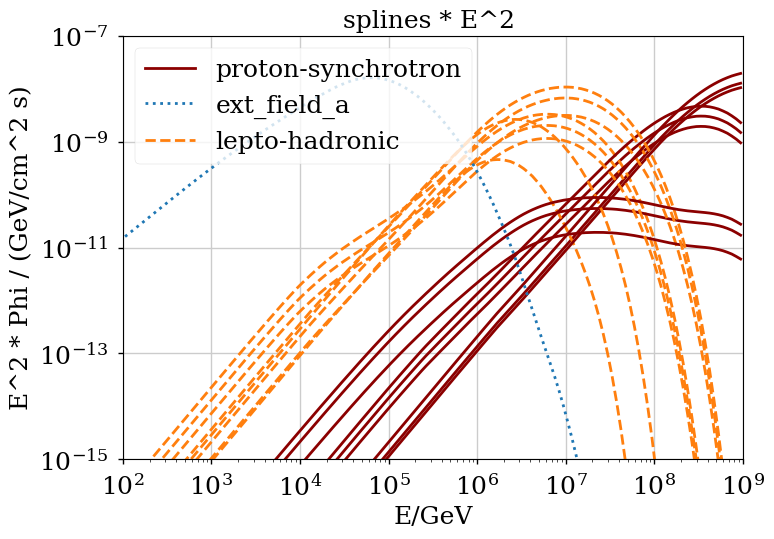

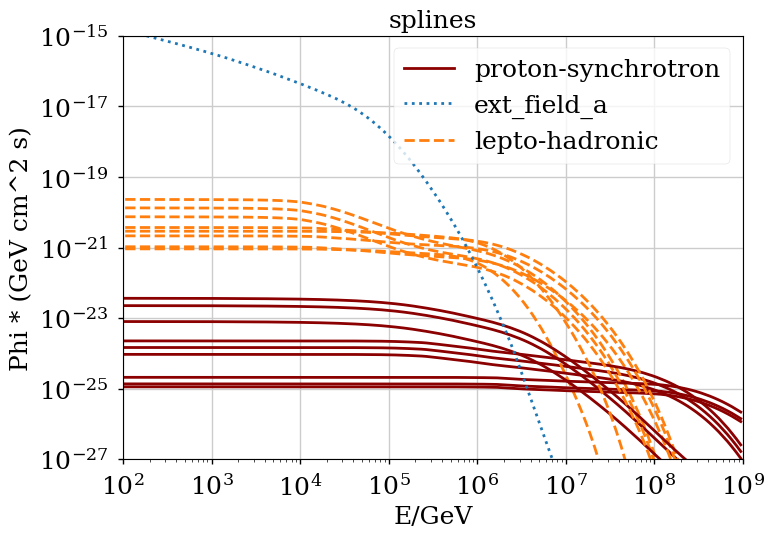

In [ ]:
tmp = []
plt.figure(1)
plt.title("raw pks")
plt.loglog()
plt.ylim(1e-15, 1e-10)
plt.xlim(1e12, 1e19)

plt.figure(3)
plt.title("splines * E^2 ")

plt.figure(4)
plt.title("splines")

for f in flare_files:
    # print(f)
    if "PSYN" in f:
        model = "proton-synchrotron"
    elif "txs" in f:
        model = "ext_field_a"
    else:
        model = "lepto-hadronic"

    if "pks_quiescent_neutrinos_bandmin" in f:
        # all zeros
        continue
    mapping = (
        {0: "E/eV", 1: "nuF/(erg/cm^2/s)"}
        if "pks" in f
        else {0: "log10(f/Hz)", 1: "log10(E^2Phi/(erg/cm^2/s))"}
    )
    dat = pd.read_csv(f, header=None).T.rename(columns=mapping)
    labels = f.split("/")[-1].split(".")[0].split("_")

    if "pks" in f:
        mask = dat["nuF/(erg/cm^2/s)"] > 0  # 1e-30
        x = np.log10(dat["E/eV"].loc[mask] / 1e9)  # eV -> GeV
        y = (
            np.log10(dat["nuF/(erg/cm^2/s)"].loc[mask] * erg_to_GeV) - 2 * x
        )  #  nu F_nu -> dN/dt dE dA
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask])
        plt.figure(1)
        ax = sns.lineplot(
            data=dat,
            x="E/eV",
            y="nuF/(erg/cm^2/s)",
            color=style[model]["color"],
            ls=style[model]["ls"],
        )

    elif "txs" in f:
        mask = dat["log10(E^2Phi/(erg/cm^2/s))"] > -100  # -30
        x = dat["log10(f/Hz)"].loc[mask] + np.log10(nu_to_GeV)  # nu -> GeV
        y = (
            dat["log10(E^2Phi/(erg/cm^2/s))"].loc[mask] + np.log10(erg_to_GeV) - 2 * x
        )  #  E² Phi [erg] -> Phi [GeV]
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask])

        plt.figure(2)
        plt.title("raw txs")
        ax = sns.lineplot(data=dat, x="log10(f/Hz)", y="log10(E^2Phi/(erg/cm^2/s))")
        ax.set_ylim(-15, -10)
        ax.set_xlim(25, 30)

    else:
        print("???")

    plt.figure(3)
    plt.plot(
        10**st.logE_mids,
        10 ** (model_spline(st.logE_mids) + 2 * st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )
    plt.figure(4)
    plt.plot(
        10**st.logE_mids,
        10 ** model_spline(st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )

    tmp.append(
        {
            "src_name": labels[0],
            "model_name": model,
            "state": labels[-3],
            "bf_or_band": labels[-1],
            "model_spline": model_spline,
            "N_nu(IC)": 0,
            "dec/rad": 0,
            "livetime/s": 0,
        }
    )

plt.figure(3)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-15, 1e-7)
plt.ylabel("E^2 * Phi / (GeV/cm^2 s)")
plt.xlabel("E/GeV")

plt.figure(4)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-27, 1e-15)
plt.ylabel("Phi * (GeV cm^2 s)")
plt.xlabel("E/GeV")

In [ ]:
flare_models_x = pd.DataFrame(tmp)
flare_models_x.loc[flare_models_x.src_name=="pks", "dec/rad"] = pks1502.dec.rad
flare_models_x.loc[flare_models_x.src_name=="pks", "livetime/s"] = 365 * 24 * 3600
flare_models_x.loc[flare_models_x.src_name=="txs", "dec/rad"] = st.txs0506.dec.rad
flare_models_x.loc[flare_models_x.src_name=="txs", "livetime/s"] = 158 * 24 * 3600

#flare_models_x
for _, series in flare_models_x.iterrows(): # .loc[flare_models_x.bf_or_band=="bestfit"]
    # if "proton" in series.model_name: continue
    print(series)
    aeff_factor_signal = calc_aeff_factor(
            aeff_2d_full["IceCube"],
            dec=series["dec/rad"],
            livetime=series["livetime/s"],
            **src_config,
        )

    nev = aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    print(np.sum(nev))
    flare_models_x.loc[_, "N_nu(IC)"] = np.sum(nev)
    print("")

src_name                                                      pks
model_name                                     proton-synchrotron
state                                                   softflare
bf_or_band                                                bestfit
model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
N_nu(IC)                                                        0
dec/rad                                                  0.183159
livetime/s                                               31536000
Name: 0, dtype: object
0.011235621047120505

src_name                                                      pks
model_name                                     proton-synchrotron
state                                                   hardflare
bf_or_band                                                bestfit
model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
N_nu(IC)                                                        0
dec/rad                        

# Plot 1D analysis slice histograms

In [ ]:
all_models = pd.concat([grb_models, flare_models_x, blazar_models], ignore_index=True)
all_models

,src_name,model_name,state,bf_or_band,N_nu(IC),model_spline,dec/rad,livetime/s,declination(degrees),DeltaT
0,GW170817,1000s moderate 0deg,grb,bestfit,1.267572e+00,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,1000,NaN,NaN
1,GW170817,1000s optimistic 4deg,grb,bestfit,1.421215e+00,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,1000,NaN,NaN
2,GW170817,3d,grb,bestfit,1.789491e-02,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,259200,NaN,NaN
3,GW170817,14d,grb,bestfit,3.955730e-02,<scipy.interpolate._fitpack2.InterpolatedUniva...,-0.408084,1209600,NaN,NaN
4,pks,proton-synchrotron,softflare,bestfit,1.123562e-02,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.183159,31536000,NaN,NaN
5,pks,proton-synchrotron,hardflare,bestfit,7.846707e-03,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.183159,31536000,NaN,NaN
6,pks,lepto-hadronic,quiescent,bestfit,9.936971e-02,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.183159,31536000,NaN,NaN
7,pks,lepto-hadronic,softflare,bandmax,4.845728e-01,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.183159,31536000,NaN,NaN
8,pks,proton-synchrotron,quiescent,bestfit,5.476615e-03,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.183159,31536000,NaN,NaN
9,pks,proton-synchrotron,hardflare,bandmin,6.474455e-03,<scipy.interpolate._fitpack2.InterpolatedUniva...,0.183159,31536000,NaN,NaN


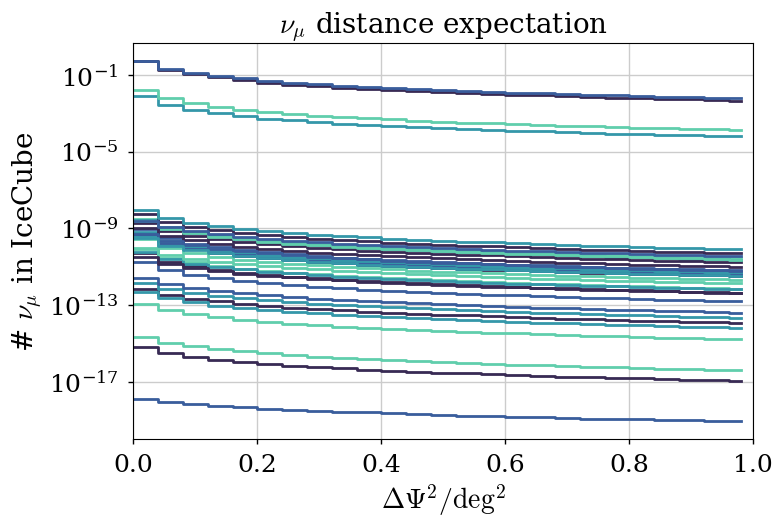

In [ ]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

f, ax = plt.subplots()
fontsize = 20
aeff_factor_signal = calc_aeff_factor(
    aeff_2d_full["IceCube"],  # ... because it's in the south
    dec=gw_170817.dec.rad,
    livetime=1,  # flare livetime is already in the fluence
    **src_config,
)
for _, row in all_models.iterrows():
    _nev = aeff_factor_signal * 10 ** row["model_spline"](st.logE_mids)

    ax.plot(
        np.concatenate([[-0.1], psi2_mids]),
        np.concatenate([[0], energy_smearing(improved_eres, _nev).sum(axis=1)]),
        label=row["model_name"],
        ds="steps-mid",
    )

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
plt.yscale("log")
# ax.set_ylim(0, 1)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

# source $\nu_\mu$ : 4.3
# atmo. $\nu_\mu$ : 112.2 (within 3 deg²)
# source $\nu_\mu$ : 4.3
# atmo. $\nu_\mu$ : 112.2 (within 3 deg²)


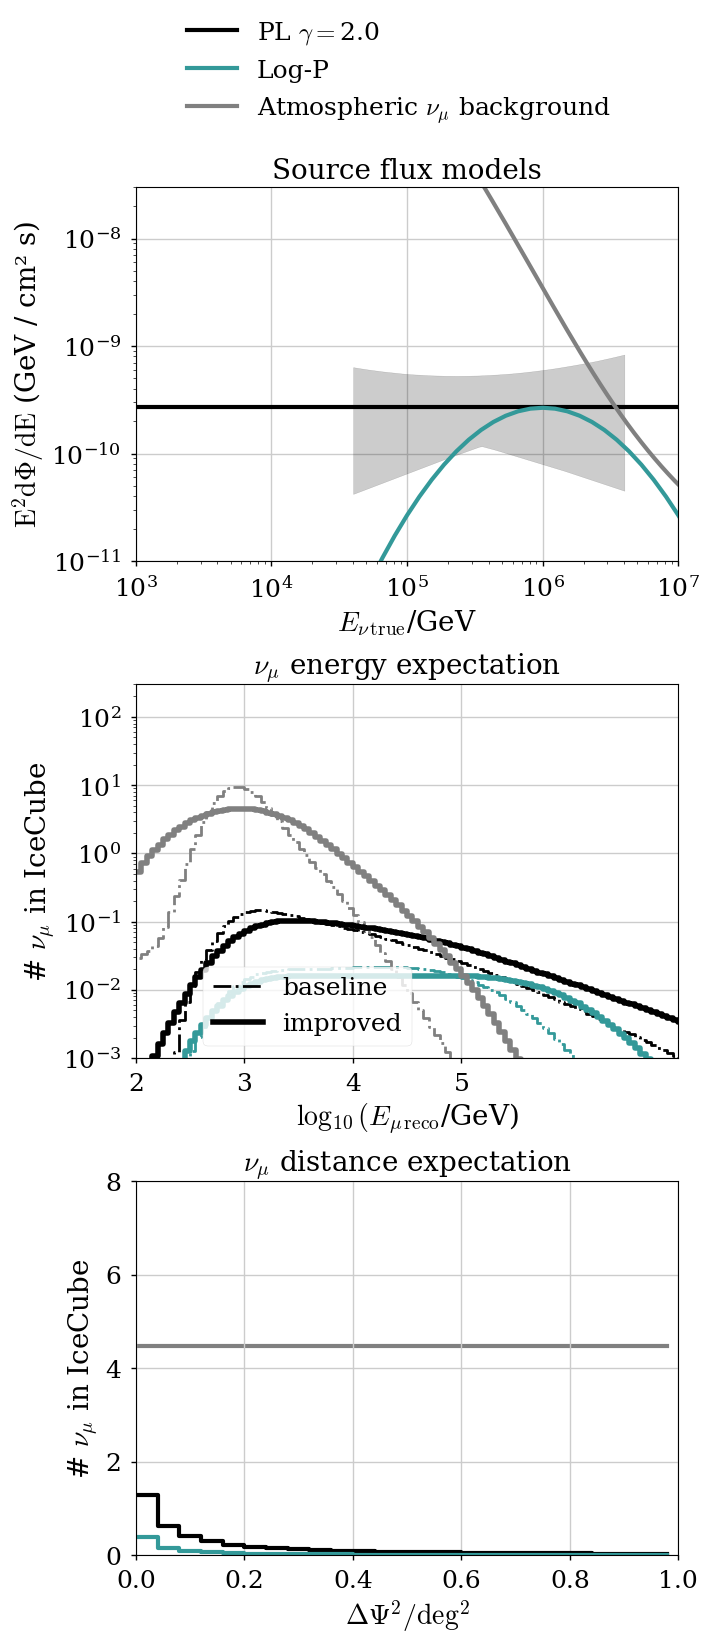

In [ ]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, E0_TXS, GAMMA_TXS, PHI_TXS)
para_idx = parabola_index(Alpha, Beta, x_evals, E_para_norm)
para = power_law(x_evals, E_para_norm, para_idx, PHI_lp)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
# without energy range interval
# x_cont = np.logspace(3, 7, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(
        xe, E0_TXS, txs_contour["68\\%"][:,0], txs_contour["68\\%"][:,1] / 1e3 / 2.8
    )  ## fudge factor :)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
    
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_TXS}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    para * (x_evals**y_scaling),
    label=rf"Log-P",
    color="#339999",
    lw=3,
)
ax.plot(
    st.emids,
    array_source_interp(
        0, bckg_histo["IceCube"], st.sindec_mids, axis=1
    )
    * sq_deg
    * (st.emids**y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
#ax.set_ylim(1e-10, 3e-5)
ax.set_ylim(1e-11, 3e-8)
ax.set_xlim(1e3, 1e7)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
evals = st.logE_reco_mids
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d_full[ident], dec=0, livetime=conservative_livetime, **bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d_full[ident], dec=0, livetime=conservative_livetime, **src_config)

for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(
            0, bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=eres,
    )

    # power law
    k_s_pl = astro_flux(
        aeff_factor_signal,
        st.emids,
        eres,
        1,
        txs_flux,
    )

    # logP
    k_s_lp = astro_flux(
        aeff_factor_signal,
        st.emids,
        eres,
        1,
        logp_flux,
    )

    ax = axes[1]
    ax.plot(
        evals,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=e_name,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_s_lp.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(3, 7)
ax.set_ylim(1e-3, 3e2)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_s_lp.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

# f.savefig(
#     join(BASEPATH, f"plots/ngc_paper/ngc_spectral_improved_dpsi.pdf"),
#     bbox_inches="tight",
# )

# Event distr in reco energy

(2.0, 9.0)

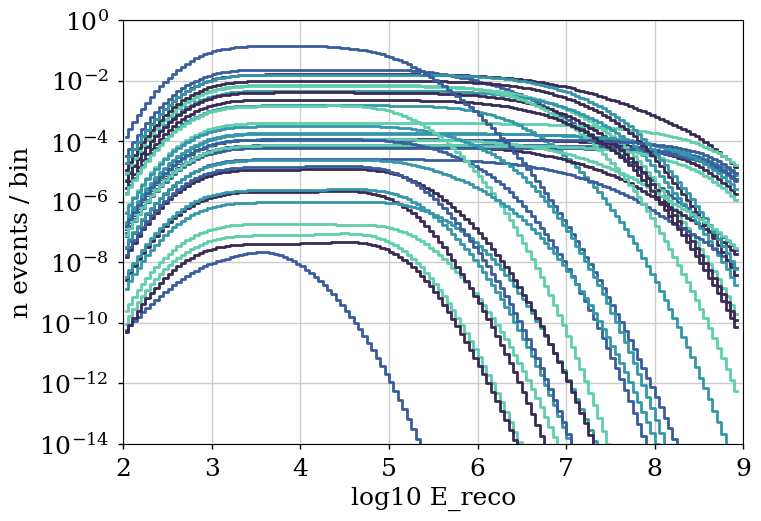

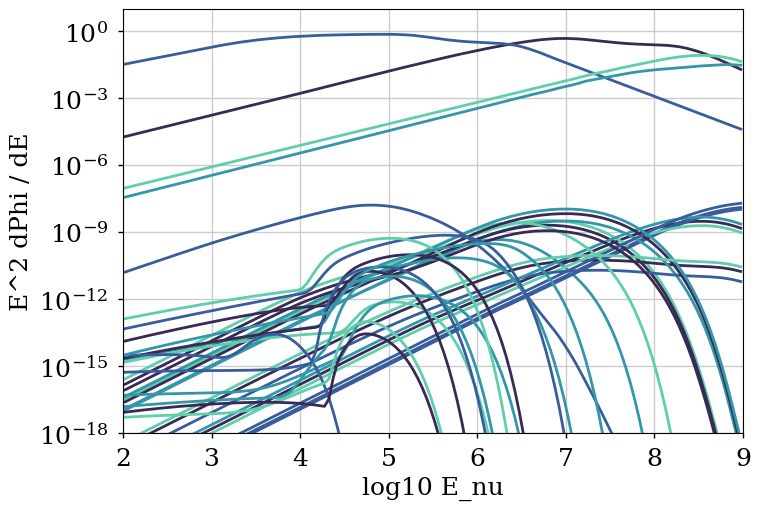

In [ ]:
for _, series in all_models.iterrows():
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"],
        dec=series["dec/rad"],
        livetime=series["livetime/s"] if series.state != "grb" else 1,
        **src_config,
    )

    nev = energy_smearing(
        improved_eres, aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    )
    plt.figure(1)
    plt.plot(st.logE_reco_mids, nev.sum(axis=0), ds="steps-mid")
    plt.figure(2)
    plt.plot(
        st.logE_mids,
        10 ** (series["model_spline"](st.logE_mids) + 2 * st.logE_mids),
    )

plt.figure(1)
plt.yscale("log")
plt.xlim(2, 9)
plt.ylabel("n events / bin")
plt.xlabel("log10 E_reco")
plt.ylim(1e-14, 1)

plt.figure(2)
plt.yscale("log")
plt.ylabel("E^2 dPhi / dE")
plt.xlabel("log10 E_nu")
plt.ylim(1e-18, 10)
plt.xlim(2, 9)

# Alert acceptance

## powerlaw model

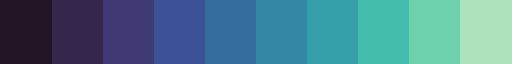

In [ ]:
_config = dict(
    sindec_mids=st.sindec_mids,
    sindec_width=st.sindec_width,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    diff_or_ps="diff",
)
if False:
    grayscale = 0.25
    cmap = ListedColormap(
        np.concatenate(
            [
                [(grayscale, grayscale, grayscale)],
                sns.color_palette("mako", n_colors=10)[1:],
            ]
        )
    )
else:
    cmap = ListedColormap(sns.color_palette("mako", n_colors=10))

cmap

In [ ]:
def add_local_horizon(time, loc, ax):
    local_horizon = SkyCoord(
        az=np.linspace(-np.pi, np.pi, 100) * u.rad,
        alt=0 * u.rad,
        frame=AltAz(obstime=time, location=loc),
    )
    cra, cdec = local_horizon.icrs.ra, local_horizon.icrs.dec
    ind = np.argsort(cra)
    cra, cdec = cra[ind], cdec[ind]
    cra = cra.wrap_at("360d")
    cra, cdec = cra.rad, cdec.rad
    ax.plot(
        cra - np.pi, cdec, marker="None", c="tomato", linewidth=1, alpha=1
    )

In [ ]:
pp, tt = np.meshgrid(st.ra_mids, np.arcsin(st.sindec_bins))
eq_coords = SkyCoord(pp * u.radian, tt * u.radian, frame="icrs")

1988.5643708790917


1043.118997451545
2704.8600587466244
16895.00401969432


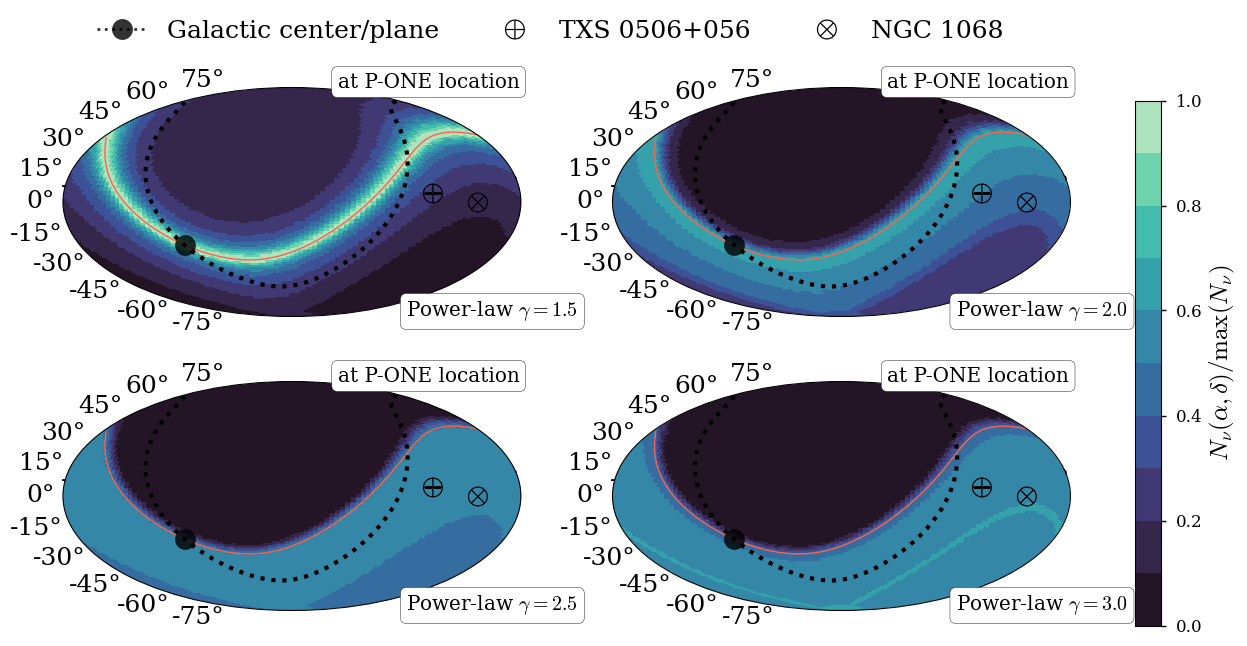

In [ ]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = {"2.0": 221, "2.3": 222, "2.7": 223, "3.0": 224}
n2ind = [221, 222, 223, 224]



for ii, gamma in enumerate(np.arange(1.5, 3.1, step=0.5)):
    diffuse_flux = PL_flux(1e-18, gamma, 1e5, "powerlaw")

    k_s = astro_flux(
        aeff_factor,
        st.emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=diffuse_flux,
    )

    print(np.sum(k_s))
    k_s /= np.sum(k_s) # normalize to 1
    
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
    

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    

    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    if ii == 0:
        max_ev = np.max(inst_ev) 
    normalized_inst_ev = inst_ev / max_ev # normalize to best acceptance for hardest gamma

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.75,
        0,
        rf"Power-law $\gamma={diffuse_flux.gamma}$",  # ,~t=t_0$",
        transform=ax.transAxes,
        fontsize="x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")
# fig.savefig(join(st.BASEPATH, "plots/skymaps_local_time.pdf"), bbox_inches="tight")

## Generic log-parabola

1043.118997451545
3.82795125406754
193.2599105135681
6598.174728438863


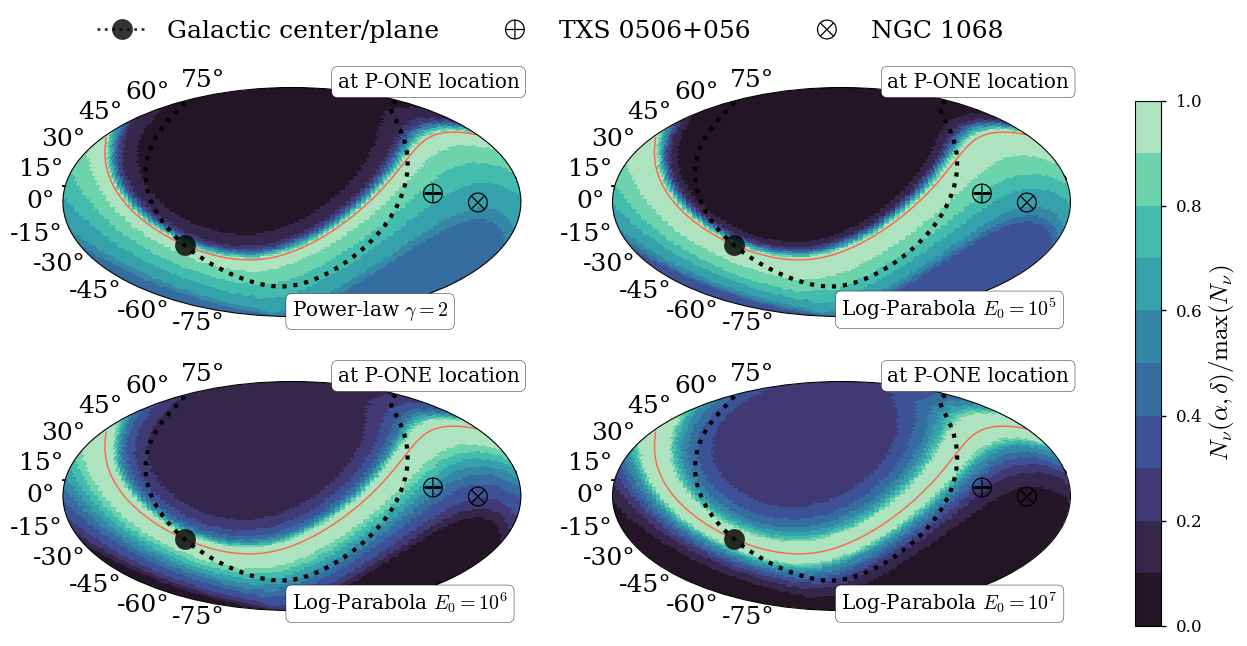

In [ ]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = {"2.0": 221, "2.3": 222, "2.7": 223, "3.0": 224}
n2ind = [221, 222, 223, 224]

for ii, e_0 in enumerate([0, 1e5, 1e6, 1e7]):
    if e_0 == 0:
        diffuse_flux = PL_flux(1e-18, 2, 1e5, "powerlaw")
    else:
        diffuse_flux = LogP_flux(1e-20, Alpha, Beta, e_0, "log-parabola")

    k_s = astro_flux(
        aeff_factor,
        st.emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=diffuse_flux,
    )

    print(np.sum(k_s))
    k_s /= np.sum(k_s)
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    if ii == 0:
        max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.5,
        0,
s= rf"Power-law $\gamma={diffuse_flux.gamma}$" if e_0 == 0 else rf"Log-Parabola $E_0=10^{{{np.log10(diffuse_flux.E0):1.0f}}}$",
        transform=ax.transAxes,
        fontsize="x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")
# fig.savefig(join(st.BASEPATH, "plots/skymaps_local_time.pdf"), bbox_inches="tight")

## specific models

In [ ]:
selected_flares = {
    "PKS 1502+106 proton-syn. (Rodrigues et al.)": flare_models_x.loc[
        (flare_models_x.bf_or_band == "bestfit")
        & (flare_models_x.src_name == "pks")
        & (flare_models_x.state == "hardflare")
        & (flare_models_x.model_name == "proton-synchrotron")
    ].iloc[0],
    "PKS 1502+106 lepto-had. (Rodrigues et al.)": flare_models_x.loc[
        (flare_models_x.bf_or_band == "bestfit")
        & (flare_models_x.src_name == "pks")
        & (flare_models_x.state == "hardflare")
        & (flare_models_x.model_name == "lepto-hadronic")
    ].iloc[0],
    "TXS 0506+056 (Rodrigues et al.)": flare_models_x.loc[
        (flare_models_x.bf_or_band == "bestfit")
        & (flare_models_x.src_name == "txs")
    ].iloc[0],
    "AO 0235+164 (Oikonomou et al.)": blazar_models.loc[blazar_models.src_name=="AO 0235+164"].iloc[0]
}
selected_flares

{'PKS 1502+106 proton-syn. (Rodrigues et al.)': src_name                                                      pks
 model_name                                     proton-synchrotron
 state                                                   hardflare
 bf_or_band                                                bestfit
 model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
 N_nu(IC)                                                 0.007847
 dec/rad                                                  0.183159
 livetime/s                                               31536000
 Name: 1, dtype: object,
 'PKS 1502+106 lepto-had. (Rodrigues et al.)': src_name                                                      pks
 model_name                                         lepto-hadronic
 state                                                   hardflare
 bf_or_band                                                bestfit
 model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
 N_nu(IC)  

### full data

3.146779799025527
48.319098938146546
660.6981681336157
15.513606716424933


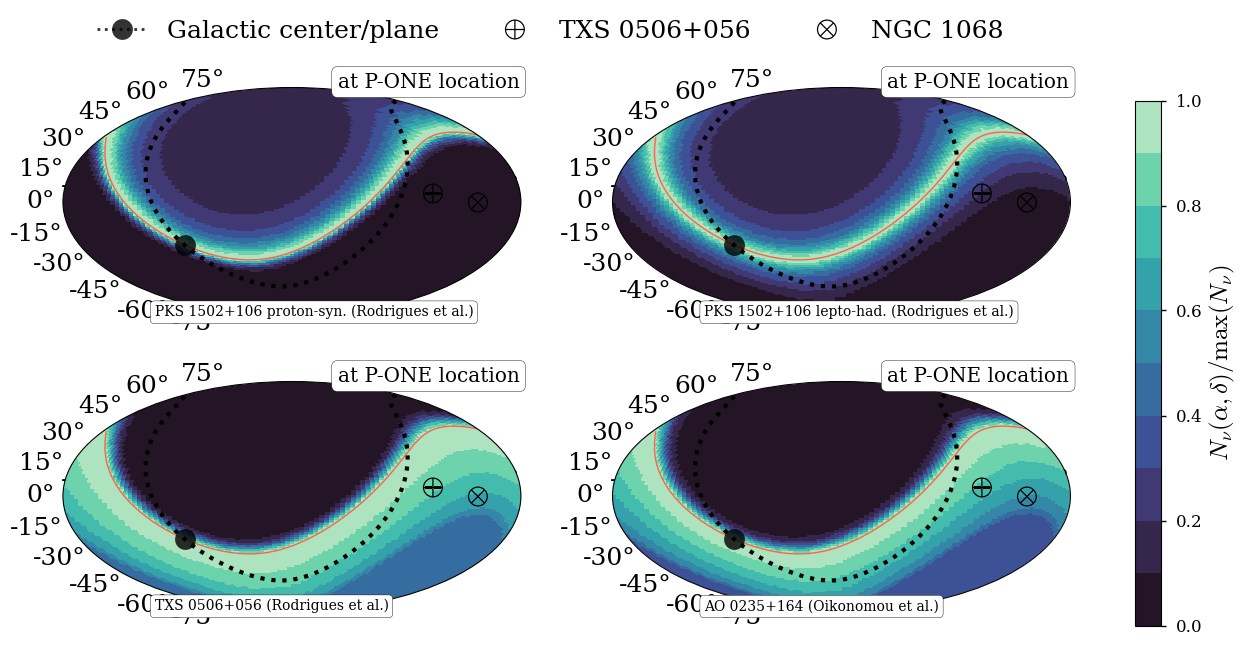

In [ ]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [221, 222, 223, 224]

for ii, dkey in enumerate(selected_flares):
    k_s = aeff_factor * 10 ** selected_flares[dkey]["model_spline"](st.logE_mids)

    print(np.sum(k_s))
    #k_s /= np.sum(k_s)
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    
    max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.2,
        0,
        s=dkey,
        transform=ax.transAxes,
        fontsize="medium", #"x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")

### E>100TeV

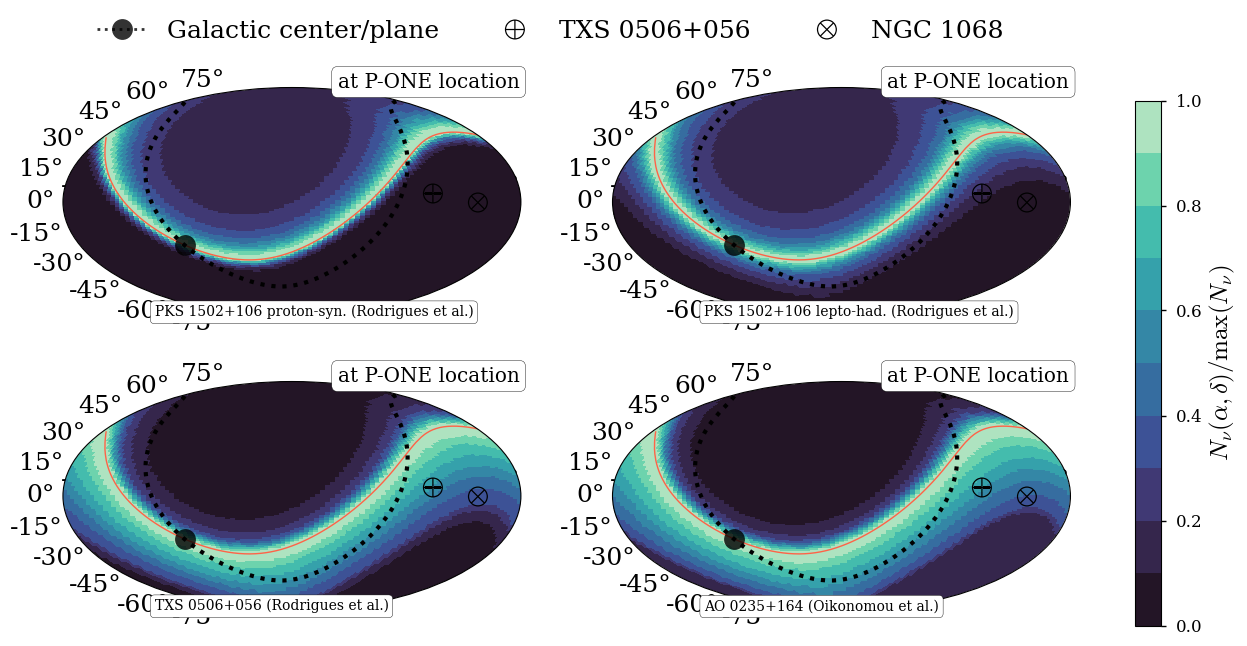

In [ ]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [221, 222, 223, 224]

for ii, dkey in enumerate(selected_flares):
    k_s = energy_smearing(baseline_eres, aeff_factor * 10 ** selected_flares[dkey]["model_spline"](st.logE_mids))

    # simple alert threshold of 100 TeV
    k_s.histo[:, st.logE_reco_mids < 5] = 0
    
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    
    max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.2,
        0,
        s=dkey,
        transform=ax.transAxes,
        fontsize="medium", #"x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [ ]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        st.emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh

def setup_multi_llh(eres, conf, bg_config, sig_config, src_flux, verbose=False, return_s_b=False):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf (tuple): Tuple containing two lists - the first list represents dataset identifiers,
                      and the second list contains corresponding scaling factors corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s (list): List of effective area factors for the signal.
            - all_aeff_factor_b (list): List of effective area factors for the background.
            - all_k (list): List of observation/Asimov data.
            - all_bckg_flux (list): List of background flux values.
            - if return_s_b: all_k_s, all_k_b (lists): List of signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k = []
    all_bckg_flux = []
    all_eres = []
    if return_s_b:
        all_k_s = []
        all_k_b = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d_full[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d_full[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], st.sindec_mids, axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(all_eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal 
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=st.emids,
            energy_resolution=current_eres,
            phi_scaling=1,
            flux_shape=src_flux,  # spectral shape
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k.append(k_s + k_b)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(current_eres)
        if return_s_b:
            all_k_s.append(k_s)
            all_k_b.append(k_b)
    if return_s_b:
        return (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        )
    else:
        return all_aeff_factor_s, all_aeff_factor_b, all_k, all_bckg_flux, all_eres

# Model tests

In [ ]:
def model_llh_single(x, mu_s, mu_b, k_i):
    # Calculate the total expected events for the Poisson LLH
    mu_i = x[0] * mu_b + x[1] * mu_s

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def model_llh_multi(x, all_mu_s, all_mu_b, all_k):
    llh = 0
    for mu_s, mu_b, k_i in zip(all_mu_s, all_mu_b, all_k):
        llh += model_llh_single(x, mu_s, mu_b, k_i)
    return llh

In [ ]:
def setup_multi_model_llh(eres, conf, bg_config, sig_config, model_spline, verbose=False):
    all_mu_s = []
    all_mu_b = []
    all_k = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d_full[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d_full[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], st.sindec_mids, axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal
        assert np.all(aeff_factor_signal.bin_mids[1] == st.logE_mids)

        k_s = energy_smearing(
            current_eres, aeff_factor_signal * 10 ** model_spline(st.logE_mids)
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_mu_s.append(k_s)
        all_mu_b.append(k_b)
        all_k.append(k_s + k_b)
    return all_mu_s, all_mu_b, all_k

## single source flare

### GRB models

In [ ]:
key = "Plenum-2"
verbose = False

for key in ["IceCube", "Plenum-1", "Plenum-2"]:
    for _, series in grb_models.iterrows():
        
        current_dec = gw_170817.dec.rad

        # setup config
        conf = detector_configurations[key]
        current_bg_config = deepcopy(bg_config)
        current_bg_config["livetime"] = series["livetime/s"]
        current_bg_config["dec"] = current_dec

        current_src_config = deepcopy(src_config)
        current_src_config["livetime"] = 1
        current_src_config["dec"] = current_dec

        all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
            improved_eres,
            conf,
            bg_config=current_bg_config,
            sig_config=current_src_config,
            model_spline=series["model_spline"],
            verbose=verbose,
        )


        local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k )
        global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k )

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )
        

        # this fit is not really needed, but good for crosschecking the minimization
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1),
            approx_grad=True,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 1) # atmo(n) vs atmo(n) + signal(n) = 1 ndof
        significance = norm.isf(pval)

        if True: #significance > 0:
            print(key)
            print(series["model_name"])
            print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        if False:
            print()
            print("Signal:", np.sum(all_mu_s))
            print("Background:", np.sum(all_mu_b))
            print("Atmo-only normalization:", out_bckg[0])
            print("Signal fit parameters:", out_comp[0])
            print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
            print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
            print(" - " * 3)
    print()

IceCube
1000s moderate 0deg
P-VALUE: 1.4590232632836103e-06 SIGNIFICANCE: 4.676505587538875
IceCube
1000s optimistic 4deg
P-VALUE: 2.3696936832553884e-07 SIGNIFICANCE: 5.036573677001203
IceCube
3d
P-VALUE: 0.6699566948490986 SIGNIFICANCE: -0.43979359045469696
IceCube
14d
P-VALUE: 0.5557416149102326 SIGNIFICANCE: -0.1401812699602946

Plenum-1
1000s moderate 0deg
P-VALUE: 2.374227032155454e-21 SIGNIFICANCE: 9.414609222457928
Plenum-1
1000s optimistic 4deg
P-VALUE: 1.0370848000170064e-68 SIGNIFICANCE: 17.478912557964804
Plenum-1
3d
P-VALUE: 0.3079368406369305 SIGNIFICANCE: 0.5017069410437669
Plenum-1
14d
P-VALUE: 0.13979686517087642 SIGNIFICANCE: 1.0812324420284

Plenum-2
1000s moderate 0deg
P-VALUE: 1.8288765346844356e-57 SIGNIFICANCE: 15.934386090673096
Plenum-2
1000s optimistic 4deg
P-VALUE: 6.406726368558142e-95 SIGNIFICANCE: 20.636854599392656
Plenum-2
3d
P-VALUE: 0.06406334833946808 SIGNIFICANCE: 1.5215307661551762
Plenum-2
14d
P-VALUE: 0.006978720562645965 SIGNIFICANCE: 2.458356842

### Foteini's models

In [ ]:
key = "Plenum-2"
verbose = False
for ii, series in blazar_models.iterrows():
    
    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = series["livetime/s"]
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )


    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k )
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k )

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1) # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval)

    if significance > 0:
        print(key)
        print(series.model_name)
        print()
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print()
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print(" - " * 3)

Plenum-2
AO 0235+164

P-VALUE: 0.40585251670113287 SIGNIFICANCE: 0.23822700448279174

Signal: 0.5910359202955162
Background: 23.961144496448238
Atmo-only normalization: [1.02479369]
Signal fit parameters: [1. 1.]
TS check: -192706.2898711823 (fit:  -192706.2898711823 )
-2 Delta LLH: 0.6909173925523646
 -  -  - 


### Xavier's models

In [ ]:
key = "Plenum-2"
verbose = False
for model_name, series in flare_models_x.iterrows():
    if series["bf_or_band"] != "bestfit":
        continue

    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = series["livetime/s"]
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k)
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval)

    if significance > 0:
        print(key)
        print(series.model_name, series.src_name, series.state)
        print()

        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print()
        print(" = " * 10)
        print()

Plenum-2
proton-synchrotron pks softflare

Signal: 0.15520504566304286
Background: 120.71940965008838
Atmo-only normalization: [1.00151814]
Signal fit parameters: [1. 1.]
TS check: -109055.30226753675 (fit:  -109055.30226753675 )
-2 Delta LLH: 1.3732984877569834

P-VALUE: 0.24124596537734144 SIGNIFICANCE: 0.7023002606551414

 =  =  =  =  =  =  =  =  =  = 

Plenum-2
proton-synchrotron pks hardflare

Signal: 0.14955516607513136
Background: 120.71940965008838
Atmo-only normalization: [1.00146094]
Signal fit parameters: [1. 1.]
TS check: -107152.58262294339 (fit:  -107152.58262294339 )
-2 Delta LLH: 1.616633845929755

P-VALUE: 0.20356178923135684 SIGNIFICANCE: 0.828966120544114

 =  =  =  =  =  =  =  =  =  = 

Plenum-2
lepto-hadronic pks quiescent

Signal: 0.9056316755228782
Background: 120.71940965008838
Atmo-only normalization: [1.00751807]
Signal fit parameters: [1. 1.]
TS check: -146028.61569307855 (fit:  -146028.61569307855 )
-2 Delta LLH: 2.7130995240586344

P-VALUE: 0.09952744252880

### all objects

In [ ]:
key = "Plenum-2"
verbose = False
for model_name, series in all_models.iterrows():
    if series["bf_or_band"] != "bestfit":
        continue

    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k)
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval)

    if True:  # significance > 0:
        print(key)
        print(series.model_name, series.src_name, series.state)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
    if False:
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print()
        print(" = " * 10)
    print()

Plenum-2
1000s moderate 0deg GW170817 grb
P-VALUE: 1.8288765346844356e-57 SIGNIFICANCE: 15.934386090673096
Signal: 14.756118942457665
Background: 0.0007672650131756355

Plenum-2
1000s optimistic 4deg GW170817 grb
P-VALUE: 6.406726368558142e-95 SIGNIFICANCE: 20.636854599392656
Signal: 70.80996122664007
Background: 0.0007672650131756355



Plenum-2
3d GW170817 grb
P-VALUE: 0.06406334833946808 SIGNIFICANCE: 1.5215307661551762
Signal: 0.18433254035910213
Background: 0.19887509141512474

Plenum-2
14d GW170817 grb
P-VALUE: 0.006978720562645965 SIGNIFICANCE: 2.4583568420371793
Signal: 0.40517866366456107
Background: 0.9280837599372488

Plenum-2
proton-synchrotron pks softflare
P-VALUE: 0.24124596537734144 SIGNIFICANCE: 0.7023002606551414
Signal: 0.15520504566304286
Background: 120.71940965008838

Plenum-2
proton-synchrotron pks hardflare
P-VALUE: 0.20356178923135684 SIGNIFICANCE: 0.828966120544114
Signal: 0.14955516607513136
Background: 120.71940965008838

Plenum-2
lepto-hadronic pks quiescent
P-VALUE: 0.09952744252880556 SIGNIFICANCE: 1.2842488861850123
Signal: 0.9056316755228782
Background: 120.71940965008838

Plenum-2
proton-synchrotron pks quiescent
P-VALUE: 0.679494281256523 SIGNIFICANCE: -0.46628510709850446
Signal: 0.05302728292526159
Background: 120.71940965008838

Plenum-2
lepto-hadronic pks softflare
P-VALUE: 0.0001

# Stacking

## GRB model

In [ ]:
# no stacking info yet

## Foteini Blazar model

In [ ]:
# index of energy treshold = 100 TeV
key = "Plenum-2"
verbose = False

stacked_mu_s = []
stacked_mu_b = []
stacked_k = []

for ii, series in blazar_models.iterrows():
    
    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = series["livetime/s"]
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    stacked_k.extend(all_k)
    stacked_mu_b.extend(all_mu_b)
    stacked_mu_s.extend(all_mu_s)

local_llh = lambda x: model_llh_multi((x[0], 0), stacked_mu_s, stacked_mu_b, stacked_k)
global_llh = lambda x: model_llh_multi(x, stacked_mu_s, stacked_mu_b, stacked_k)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)


# this fit is not really needed, but good for crosschecking the minimization
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1),
    approx_grad=True,
)

pval = chi2.sf(
    out_bckg[1] - out_comp[1], 1
)  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
significance = norm.isf(pval)

if True:  # significance > 0:
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("Signal:", np.sum(stacked_mu_s))
    print("Background:", np.sum(stacked_mu_b))
    print("Atmo-only normalization:", out_bckg[0])
    print("Signal fit parameters:", out_comp[0])

    print(
        "TS check:",
        global_llh((1, 1)),
        "(fit: ",
        out_comp[1],
        ")",
        "(bckg: ",
        out_bckg[1],
        ")",
    )
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    print(" - " * 3)

P-VALUE: 0.3120239302239777 SIGNIFICANCE: 0.4901215912123318
Signal: 0.825488111917679
Background: 156.602512026588
Atmo-only normalization: [1.00599844]
Signal fit parameters: [1. 1.]
TS check: -2887286.875312227 (fit:  -2887286.875312227 ) (bckg:  -2887285.853222913 )
-2 Delta LLH: 1.0220893137156963
 -  -  - 


## Xavier's models

In [ ]:
# no stacking info yet

# Declination DP

In [ ]:
selected_models = {
    "PKS 1502+106 lepto-had. (Rodrigues et al.)": flare_models_x.loc[
        (flare_models_x.bf_or_band == "bestfit")
        & (flare_models_x.src_name == "pks")
        & (flare_models_x.state == "hardflare")
        & (flare_models_x.model_name == "lepto-hadronic")
    ].iloc[0],
    "TXS 0506+056 (Rodrigues et al.)": flare_models_x.loc[
        (flare_models_x.bf_or_band == "bestfit") & (flare_models_x.src_name == "txs")
    ].iloc[0],
    "AO 0235+164 (Oikonomou et al.)": blazar_models.loc[
        blazar_models.src_name == "AO 0235+164"
    ].iloc[0],
    "GW170817-GRB 14-day (Fang & Metzger)": grb_models.loc[
        grb_models.model_name == "14d"
    ].iloc[0],
}
# selected_models

In [ ]:
thresholds = [st.sigma5]

detector_keys = [
    "IceCube" ,
    #"P-ONE" ,
    #"Plenum-1",
    "Plenum-2",
]
decs = [-30, 0, 30]
for current_dec, key, (model_key, series) in product(decs, detector_keys, selected_models.items()):
    
    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = current_dec
    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = current_dec

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k)
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval)

    if True:  # significance > 0:
        print(key, dec, series.model_name, series.src_name, series.state)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
    if False:
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print()
        print(" = " * 10)
    print()

TypeError: Operation not defined for this <class 'numpy.int64'>

# ideas:
* multi flare stack
* PEs
* cut on lower energy
* ??

In [ ]:
raise BaseException("BIS HIER HIN UND NICHT WEITER >:O")

BaseException: BISHIERHINUNDNICHTWEITER >:O

# Time Dependent

## fixed fluence

In [ ]:
verbose = False
PHI_ref = 2e-22
tmp_flux = LogP_flux(PHI_ref, Alpha, Beta, E_para_norm, "log-parabola")
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]

livetimes = np.array([10, 100, 365, 2*365, 1000, 5*365, 10*365]) * 24 * 3600
tmp = []
for dT in livetimes:
    T = float(dT) # whyyyy

    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"], dec=0, livetime=T, **src_config
    )

    k_s = astro_flux(
        aeff_factor_signal,
        st.emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux,
    )

    current_flux = LogP_flux(
        PHI_ref / np.sum(k_s), Alpha, Beta, E_para_norm, "log-parabola"
    )

    for key in detector_keys:
        conf = detector_configurations[key]
        #print(key)
        current_bg_config = deepcopy(bg_config)
        current_bg_config["livetime"] = T
        current_bg_config["dec"] = 0

        current_src_config = deepcopy(src_config)
        current_src_config["livetime"] = T
        current_src_config["dec"] = 0

        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            improved_eres,
            conf,
            bg_config=current_bg_config,
            sig_config=current_src_config,
            src_flux=current_flux,
        )

        dct = dict(
            shape="log-parabola",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=current_flux.E0,
            phi_0=current_flux.norm,
        )

        # fix signal normalization to 0
        local_llh = lambda x: ps_llh_multi((x[0], 0, 1, 1), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the minimization
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, logp_flux.alpha, logp_flux.beta),
            approx_grad=True,
        )
        

        pval = chi2.sf(
            out_bckg[1] - out_comp[1], 3
        )  # atmo(n) vs atmo(n) + signal(n, alpha, beta) = 3 ndof
        significance = norm.isf(pval)
        if verbose:
            print("Atmo-only normalization:", out_bckg[0])
            print("Signal fit parameters:", out_comp[0])
            print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
            print(
            "TS check:",
            global_llh((1, 1, logp_flux.alpha, logp_flux.beta)),
            "(fit: ",
            out_comp[1],
            ")",
        )
            print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
            print()

        tmp.append({
            "livetime": dT,
            "pval": pval,
            "significance": significance,
            "detector": key
        })
df = pd.DataFrame(tmp)

<Axes: xlabel='livetime', ylabel='significance'>

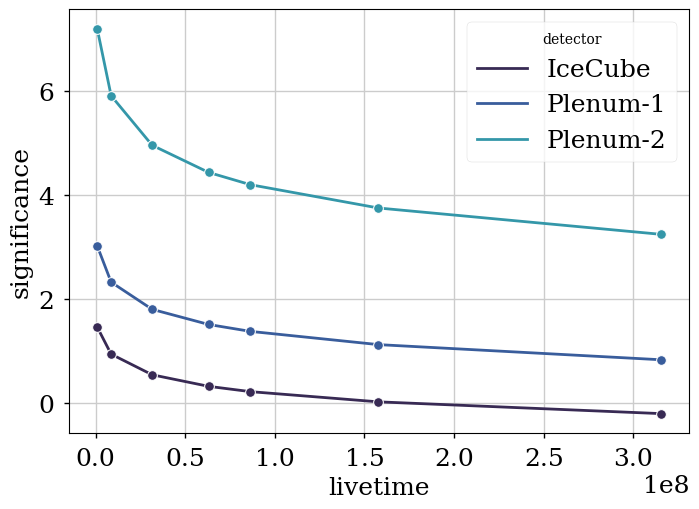

In [ ]:
sns.lineplot(df, x="livetime", y="significance", hue="detector", marker="o")

## discovery potential

fix the livetime and see which fluxes can be discovered

In [ ]:
thresholds = [st.sigma5]

PHI_ref = 2e-22
ref_flux = LogP_flux(PHI_ref, Alpha, Beta, E_para_norm, "log-parabola")

detector_keys = [
    "IceCube" ,
    #"P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = [-30, 0, 30]
livetimes = np.array([10, 100, 1000,]) * 24 * 3600 #np.array([10, 100, 365, 2*365, 1000, 5*365, 10*365]) * 24 * 3600

tmp = []  # save output here

for ident, dT, d_dec in product(detector_keys, livetimes, decs):
    dec = np.deg2rad(d_dec)
    T = float(dT) # whyyyy
    conf = detector_configurations[ident]
    if "IceCube" in ident and dec < np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue

    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["livetime"] = T
    cur_bg_conf["dec"] = dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["livetime"] = T
    cur_sig_conf["dec"] = dec

    # set up all ingredients for the multi-sample likelihood calculation
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        energy_reso["improved"],  # select one resolution for all data sets
        conf,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=ref_flux
    )
    # calculate an estimate for the flux scaling
    scaler = 0.35 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        # scale the number of signal events - equivalent to scaling the flux
        current_k_s = [ks * scaler for ks in all_k_s]
        current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

        dct = dict(
            shape="log-parabola",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=current_k_i,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=logp_flux.E0,
            phi_0=logp_flux.norm,
        )
        # fix signal contribution to 0 for background fit
        local_llh = lambda x: ps_llh_multi((x[0], 0, 1, 1), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, logp_flux.alpha, logp_flux.beta),
            bounds=([1E-3, 10], [1E-3, 10], [1, 5], [-2, 2]),
            approx_grad=True,
        )

        tmp_dct = {
            "ident": ident,
            "livetime": T,
            "dec": d_dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
            "SoB": np.sum(current_k_s) /np.sum(all_k_b),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(current_k_s),
            "p": chi2.sf(out_bckg[1] - out_comp[1], 3),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 3)), # atmo(n) vs atmo(n) + signal(n, alpha, beta) = 3 ndof
        }
        if np.isnan(tmp_dct["p"]):
            print(out_bckg[1], out_comp[1], out_bckg[1] - out_comp[1])
            raise ValueError(">:O")
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == d_dec)
            & (tmp_df.ident == ident)
            & (tmp_df.livetime == T)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "logP_disc_pot_timedep.pickle"))

Optimization failed! Diff is: 0.44728819594027147 thresh is: 2.866515719235352e-07


### plotting

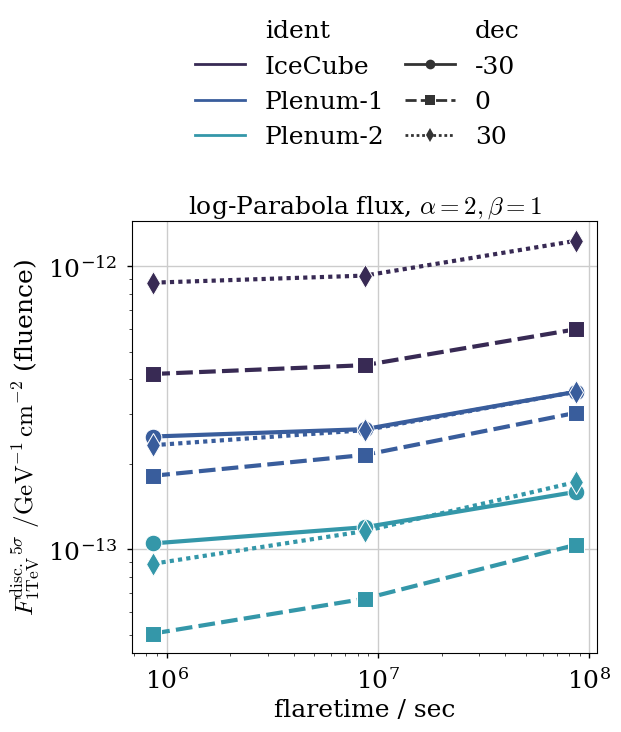

In [ ]:
df = pd.read_pickle(join(st.LOCALPATH, "logP_disc_pot_timedep.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "livetime"]).apply(lambda x: get_scaler(x, st.sigma5))
    * logp_flux.norm,
    columns=["disc5"],
).reset_index()

flux["fluence5"] = flux.disc5 * flux.livetime


f, ax = plt.subplots(figsize=(6, 8))
sns.lineplot(
    flux,
    x="livetime",
    y="fluence5",
    hue="ident",
    style="dec",
    lw="3",
    markers=["o", "s", "d"],
    ms=12,
)
# for (ident, dec), series in flux.groupby(["ident", "dec"]):
#     plt.plot(
#         series.livetime,
#         series.fluence5,
#         lw=3,
#         **{k: det_plotting[ident][k] for k in ["ls", "color"]} # "label"
#     )
ax.set_yscale("log")
ax.set_xscale("log")
# ax.axhline(logp_flux.norm, ls="--", lw=2, color="k", zorder=0)
# ax.axhline(logp_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
# ax.axhline(logp_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
ax.axes.legend_.remove()
ax.set_xlabel(r"flaretime / sec")
ax.set_ylabel(
    r"$F^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} $ (fluence)"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
# ax.set_ylim(8e-15, 1e-13)
# ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.65)
ax.set_title(rf"log-Parabola flux, $\alpha={Alpha}, \beta={Beta}$")

f.savefig(
    join(st.BASEPATH, "plots/icrc2023/logP_disc_pot_timedep.pdf"), bbox_inches="tight"
)

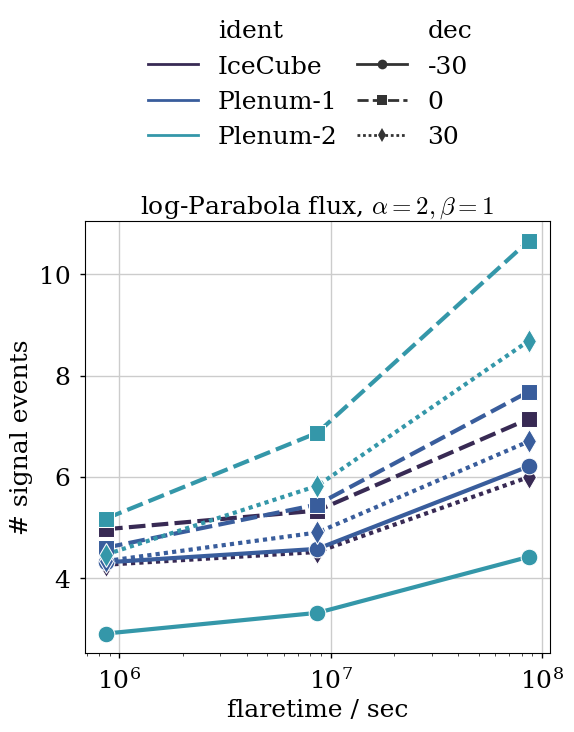

In [ ]:
df = pd.read_pickle(join(st.LOCALPATH, "logP_disc_pot_timedep.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "livetime"]).apply(lambda x: get_scaler(x, st.sigma5, key_y="n_sig")),
    columns=["disc5"],
).reset_index()


f, ax = plt.subplots(figsize=(6, 8))
sns.lineplot(
    flux,
    x="livetime",
    y="disc5",
    hue="ident",
    style="dec",
    lw="3",
    markers=["o", "s", "d"],
    ms=12,
)
# for (ident, dec), series in flux.groupby(["ident", "dec"]):
#     plt.plot(
#         series.livetime,
#         series.fluence5,
#         lw=3,
#         **{k: det_plotting[ident][k] for k in ["ls", "color"]} # "label"
#     )
#ax.set_yscale("log")
ax.set_xscale("log")
# ax.axhline(logp_flux.norm, ls="--", lw=2, color="k", zorder=0)
# ax.axhline(logp_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
# ax.axhline(logp_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
ax.axes.legend_.remove()
ax.set_xlabel(r"flaretime / sec")
ax.set_ylabel("# signal events")
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
# ax.set_ylim(8e-15, 1e-13)
# ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.65)
ax.set_title(rf"log-Parabola flux, $\alpha={Alpha}, \beta={Beta}$")

f.savefig(
    join(st.BASEPATH, "plots/icrc2023/logP_disc_pot_timedep.pdf"), bbox_inches="tight"
)